In [54]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
df = pd.read_csv('multivariate_eng_df.csv', parse_dates=['Date'])
df.head()

,Date,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
0,2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
1,2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2,2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
3,2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
4,2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [55]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

#separate univariate dataframe for california
ca_uni_df = ca_df[['Date', 'PEOPLE_POSITIVE_NEW_CASES_COUNT']]
ca_uni_df = ca_uni_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})


In [56]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

In [57]:
#use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()
#fit the model on the training dataset
model_baseline.fit(ca_uni_train)

17:13:20 - cmdstanpy - INFO - Chain [1] start processing


17:13:20 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
print(len(ca_uni_test))

158


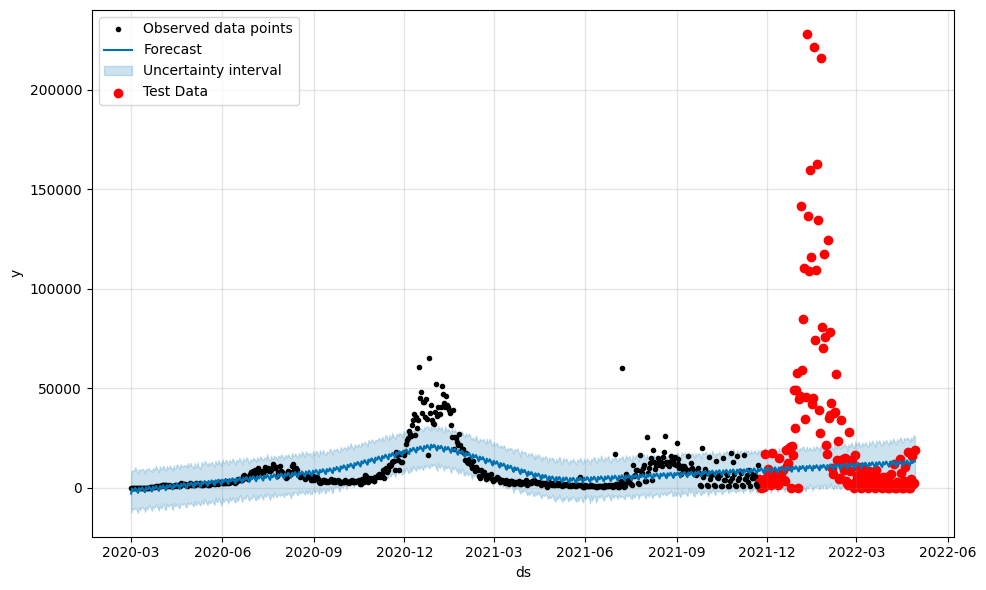

In [59]:
#create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=158)
#make prediction
forecast_baseline = model_baseline.predict(future_baseline)
#visualize the forecast
model_baseline.plot(forecast_baseline); #add semi-colon to remove the duplicated chart
plt.scatter(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Test Data')

# Enhance the plot
plt.legend()
plt.show()

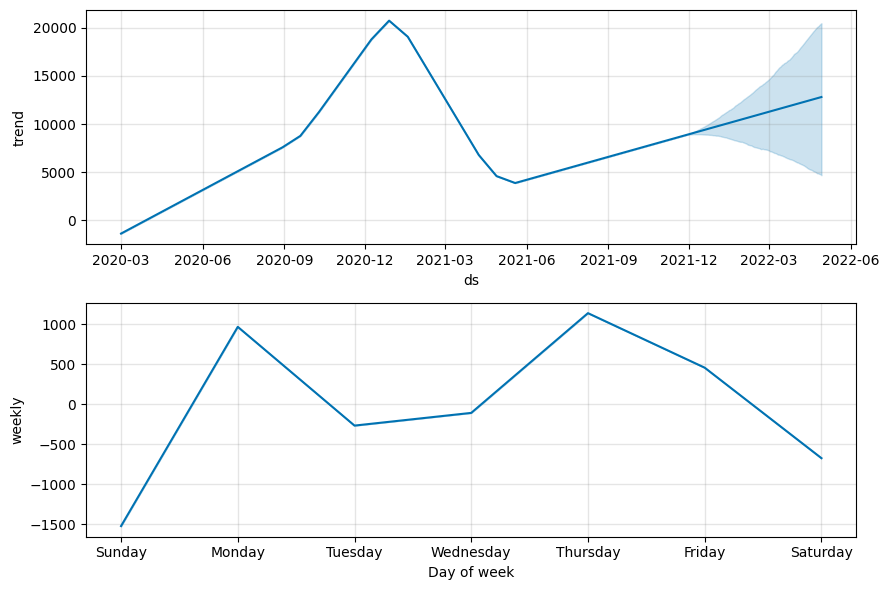

In [60]:
#visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [61]:
#merge actual and predicted values
performance_baseline = pd.merge(ca_uni_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-158:], on='ds')

#check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

#check MAPE value
#performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
#print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

#naive forecast for mase calculation
naive_forecast = ca_uni_test['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['y'][1:], naive_forecast.dropna())
mase = performance_baseline_MAE / mae_naive


#calculate performance metrics
mse = mean_squared_error(performance_baseline['y'], performance_baseline['yhat'])
rmse = np.sqrt(mse)
print('Test RMSE for the baseline model is: ', rmse)
print('Test MASE for the baseline model is: ', mase)

The MAE for the baseline model is 24094.385240881667
Test RMSE for the baseline model is:  46966.48191825491
Test MASE for the baseline model is:  1.2236258400316036


SEASONAL UNIVARIATE PROPHET

In [62]:
#add seasonality into the model
#add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
#fit the model on the training dataset
model_season.fit(ca_uni_train)

17:13:25 - cmdstanpy - INFO - Chain [1] start processing
17:13:25 - cmdstanpy - INFO - Chain [1] done processing


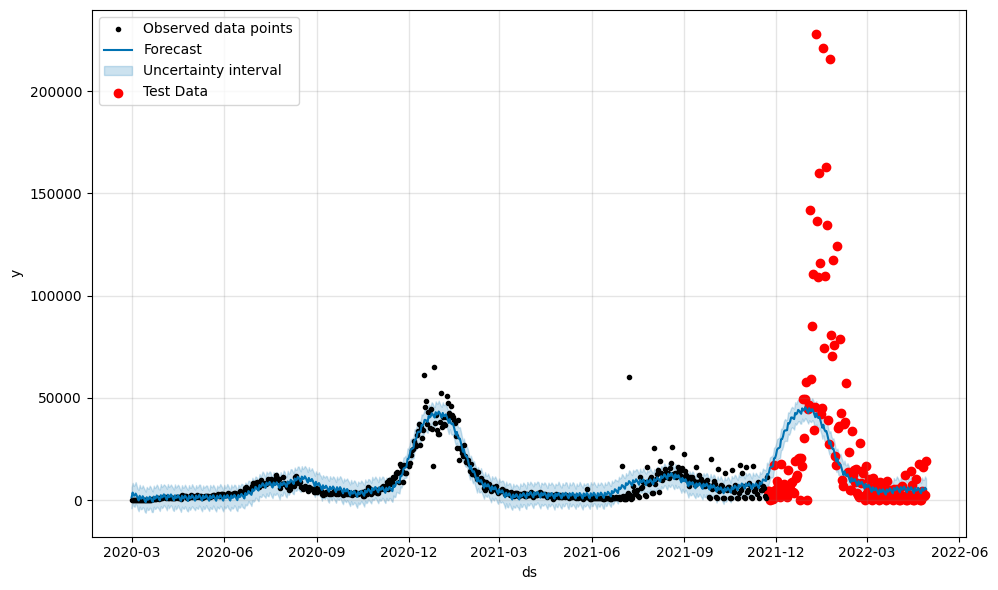

In [63]:
#create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=158)

#make predictions
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season); 
plt.scatter(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Test Data')
plt.legend()
plt.show()

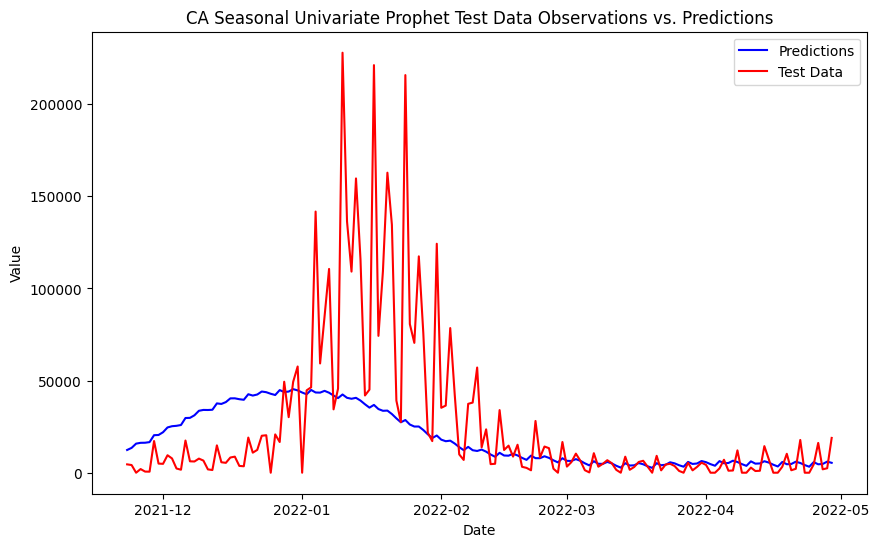

In [64]:
#graph only the range of dates covered by the test data
#filter the forecast data to only include rows where the 'ds' value is within the range of the test dataset
test_period_start = ca_uni_test['ds'].min()
test_period_end = ca_uni_test['ds'].max()

filtered_forecast = forecast_season[(forecast_season['ds'] >= test_period_start)]

plt.figure(figsize=(10, 6))
plt.plot(filtered_forecast['ds'], filtered_forecast['yhat'], label='Predictions', color='blue')

#overlay the actual test data
plt.plot(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Test Data')
plt.legend()
plt.title('CA Seasonal Univariate Prophet Test Data Observations vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

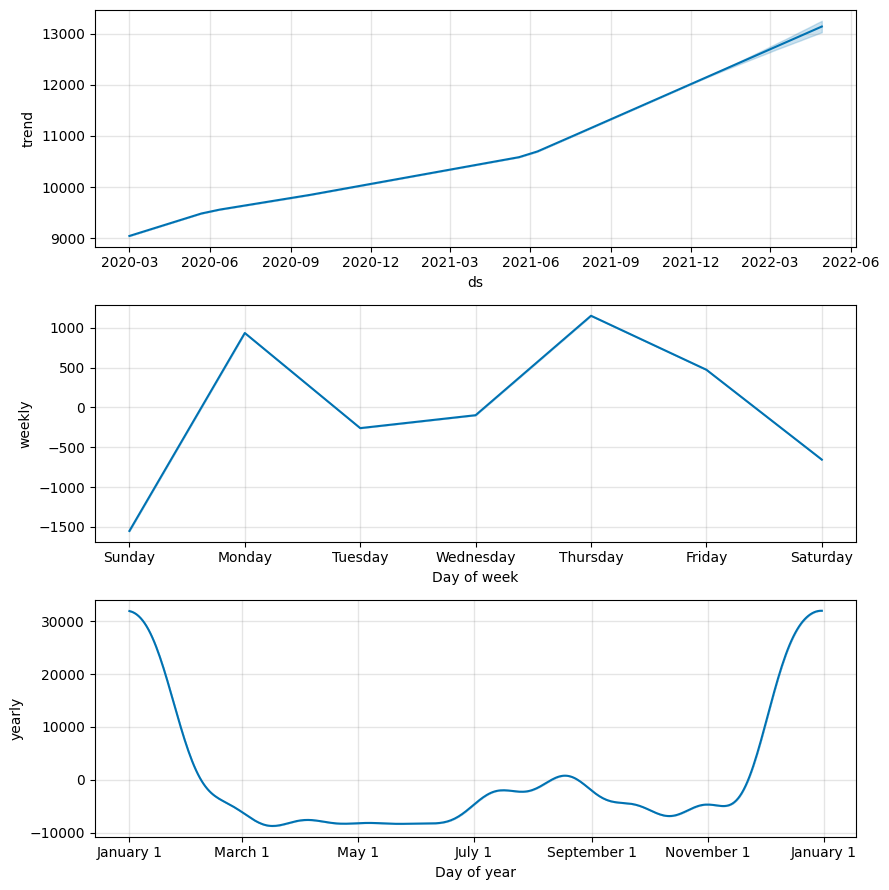

In [65]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [66]:
#merge actual and predicted values
performance_season = pd.merge(ca_uni_test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-158:], on='ds')

#calculate performance metrics
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'Test MAE for seasonal model: {performance_season_MAE}')

#calculate mape
#performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
#print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

mse = mean_squared_error(performance_season['y'], performance_season['yhat'])
rmse = np.sqrt(mse)
print('Test RMSE for seasonal model: ', rmse)

#naive forecast for mase calculation
naive_forecast = ca_uni_test['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['y'][1:], naive_forecast.dropna())
mase = performance_season_MAE / mae_naive
print('Test MASE for seasonal model: ', mase)

Test MAE for seasonal model: 21107.58917233664
Test RMSE for seasonal model:  39850.460931266076
Test MASE for seasonal model:  1.0719423331963502


HYPERPARAMETER TUNING

In [67]:
ca_uni_df

,ds,y
0,2020-03-01,5
1,2020-03-02,5
2,2020-03-03,7
3,2020-03-04,10
4,2020-03-05,12
...,...,...
785,2022-04-25,4531
786,2022-04-26,16180
787,2022-04-27,1852
788,2022-04-28,2427


In [68]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
best_score = np.inf
best_params = None

for params in ParameterGrid(param_grid):
    scores = []
    for train_idx, test_idx in tscv.split(ca_uni_df):

        train = ca_uni_df.iloc[train_idx][['ds', 'y']]
        test = ca_uni_df.iloc[test_idx][['ds', 'y']]


        model = Prophet(**params, yearly_seasonality = True, weekly_seasonality = True).fit(train)
        forecast = model.predict(test[['ds']])
        #change negative predictions to 0
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
        
        score = mean_squared_error(test['y'], forecast['yhat'])
        scores.append(score)

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print(f"Best Parameters: {best_params}")


17:13:32 - cmdstanpy - INFO - Chain [1] start processing
17:13:32 - cmdstanpy - INFO - Chain [1] done processing
17:13:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


17:13:32 - cmdstanpy - INFO - Chain [1] start processing
17:13:33 - cmdstanpy - INFO - Chain [1] done processing
17:13:33 - cmdstanpy - INFO - Chain [1] start processing
17:13:33 - cmdstanpy - INFO - Chain [1] done processing
17:13:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:13:33 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
17:13:34 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
17:13:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:13:34 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
17:13:35 - cmdstanpy - INFO - Chain [1] start processing
17:13:35 - cmdstanpy - INFO - Chain [1] done processing
17:13:35 -

Best Parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


In [33]:
#train model with optimal hyperparameters
model_tuned = Prophet(yearly_seasonality = True, weekly_seasonality = True, changepoint_prior_scale = 0.001, holidays_prior_scale  = 0.1, seasonality_mode = 'additive', seasonality_prior_scale = 0.1)
#fit the model on the training dataset
model_tuned.fit(ca_uni_train)

12:39:49 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing


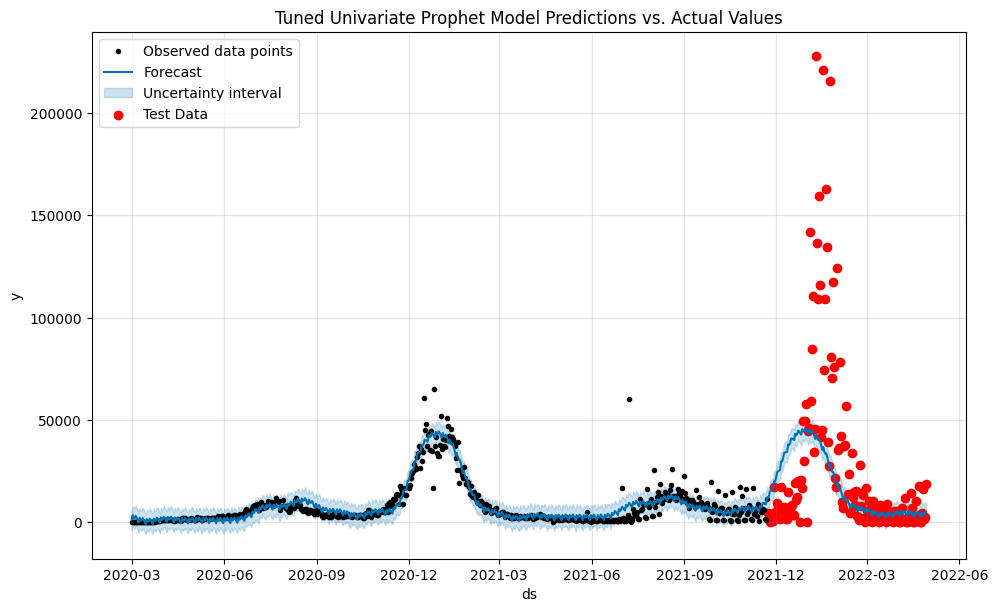

In [36]:
#create the time range for the forecast
future_season_tuned = model_tuned.make_future_dataframe(periods=158)

#make predictions
forecast_season_tuned = model_tuned.predict(future_season_tuned)
model_tuned.plot(forecast_season_tuned); 
plt.scatter(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Test Data')
plt.title('Tuned Univariate Prophet Model Predictions vs. Actual Values')
plt.legend()
plt.show()

In [37]:
#merge actual and predicted values
performance_season_tuned = pd.merge(ca_uni_test, forecast_season_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-158:], on='ds')

#calculate performance metrics
performance_season_tuned_MAE = mean_absolute_error(performance_season_tuned['y'], performance_season_tuned['yhat'])
print(f'Test MAE for tuned seasonal model: {performance_season_tuned_MAE}')

#calculate mape
#performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
#print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

tuned_mse = mean_squared_error(performance_season_tuned['y'], performance_season_tuned['yhat'])
tuned_rmse = np.sqrt(tuned_mse)
print('Test RMSE for tuned seasonal model: ', tuned_rmse)

#naive forecast for mase calculation
naive_forecast = ca_uni_test['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['y'][1:], naive_forecast.dropna())
mase = performance_season_tuned_MAE / mae_naive
print('Test MASE for tuned seasonal model: ', mase)

Test MAE for tuned seasonal model: 21111.977172063787
Test RMSE for tuned seasonal model:  39961.871950880435
Test MASE for tuned seasonal model:  1.072165176393988
